In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Machine Learning libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# This is where the raw .npy files are currently stored
RAW_DATA_DIR = Path("dataset/static")

# This is the file we want to create/load
CSV_FILE = Path("dataset.csv")

In [ ]:
def generate_column_names():
    """Generates column names: x0, y0, z0, ..., x20, y20, z20, class"""
    cols = []
    for i in range(21):
        cols.extend([f'x{i}', f'y{i}', f'z{i}'])
    cols.append('class')
    return cols

def get_or_create_dataset(csv_path, data_dir):
    """
    1. Checks if dataset.csv exists.
    2. If YES -> Loads it directly (Fast).
    3. If NO -> Scans folders, builds dataframe, saves to CSV (Slow, but done once).
    """
    # --- SCENARIO 1: CSV EXISTS ---
    if csv_path.exists():
        print(f"Found '{csv_path}'! Loading directly...")
        try:
            df = pd.read_csv(csv_path)
            print(f"Loaded {len(df)} samples.")
            return df
        except Exception as e:
            print(f"Error reading CSV: {e}")
            return None

    # --- SCENARIO 2: CSV DOES NOT EXIST (Create it) ---
    print(f"'{csv_path}' not found. Building dataset from {data_dir}...")
    
    if not data_dir.exists():
        print(f"Error: Raw data directory '{data_dir}' not found!")
        return None

    class_folders = [d for d in data_dir.iterdir() if d.is_dir()]
    all_data = []
    
    for folder in class_folders:
        class_name = folder.name
        npy_files = list(folder.glob('*.npy'))
        print(f"Processing class '{class_name}': found {len(npy_files)} files")
        
        for file in npy_files:
            try:
                features = np.load(file)
                if features.shape == (63,):
                    # Convert to list and append class label
                    row = list(features) + [class_name]
                    all_data.append(row)
            except:
                pass # Skip bad files

    if not all_data:
        print("No valid data found in folders.")
        return None

    # Create DataFrame
    df = pd.DataFrame(all_data, columns=generate_column_names())
    
    # Save to CSV for next time
    df.to_csv(csv_path, index=False)
    print(f"\nSuccess! Created '{csv_path}' with {len(df)} samples.")
    
    return df

# --- EXECUTE LOAD ---
df = get_or_create_dataset(CSV_FILE, RAW_DATA_DIR)

# Display result
if df is not None:
    print("\nClass Distribution:")
    print(df['class'].value_counts())
    display(df.head())

Found 'dataset.csv'! Loading directly...
Loaded 7000 samples.

Class Distribution:
class
A    500
B    500
C    500
D    500
E    500
F    500
H    500
I    500
K    500
L    500
M    500
N    500
O    500
Y    500
Name: count, dtype: int64


,lm_0_x,lm_0_y,lm_0_z,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,...,lm_18_x,lm_18_y,lm_18_z,lm_19_x,lm_19_y,lm_19_z,lm_20_x,lm_20_y,lm_20_z,class
0,0.0,0.0,0.0,-0.198788,0.161754,0.090969,-0.287160,0.473974,0.111990,-0.260601,...,0.307439,0.664359,0.082501,0.232397,0.469582,0.068253,0.178090,0.336900,0.031229,A
1,0.0,0.0,0.0,-0.199615,0.172622,0.088430,-0.285965,0.479364,0.111692,-0.260935,...,0.299085,0.672090,0.083365,0.221825,0.481311,0.072019,0.163604,0.336735,0.038769,A
2,0.0,0.0,0.0,-0.199508,0.172060,0.087093,-0.290975,0.485463,0.110387,-0.269007,...,0.299814,0.682880,0.082162,0.238427,0.521599,0.069602,0.191053,0.389173,0.035259,A
3,0.0,0.0,0.0,-0.201326,0.168583,0.093336,-0.286695,0.480567,0.116854,-0.257876,...,0.303849,0.667428,0.079976,0.229006,0.483800,0.062598,0.178603,0.357413,0.023226,A
4,0.0,0.0,0.0,-0.200269,0.163656,0.094012,-0.286295,0.475382,0.118510,-0.260957,...,0.288892,0.661898,0.081127,0.218115,0.476232,0.061703,0.177600,0.353720,0.020229,A


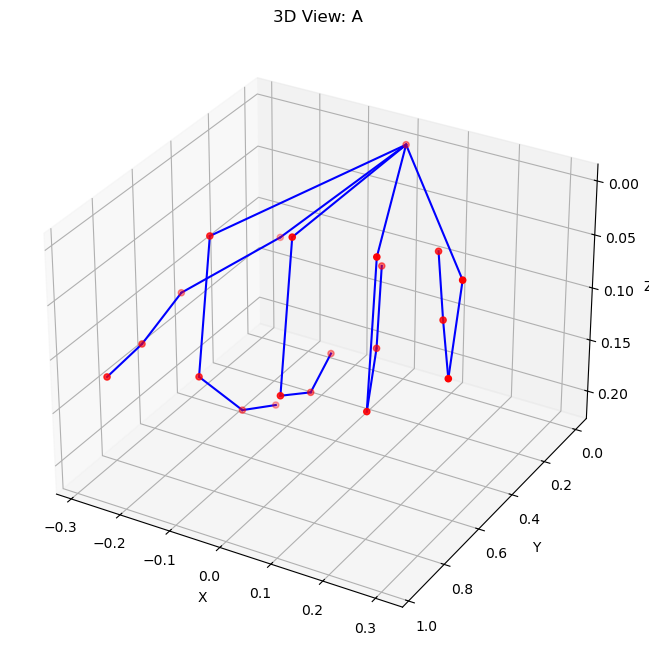

In [3]:
def plot_hand_3d(df, class_label, index=0):
    if df is None: return

    # Filter for the specific class
    class_data = df[df['class'] == class_label]
    if class_data.empty:
        print(f"No data for class {class_label}")
        return

    # Get features (first 63 cols)
    sample = class_data.iloc[index, :63].values.astype(float)
    points = sample.reshape(21, 3)
    
    # Connections
    bones = [
        (0,1), (1,2), (2,3), (3,4),       # Thumb
        (0,5), (5,6), (6,7), (7,8),       # Index
        (0,9), (9,10), (10,11), (11,12),  # Middle
        (0,13), (13,14), (14,15), (15,16),# Ring
        (0,17), (17,18), (18,19), (19,20) # Pinky
    ]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Draw Points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='red')

    # Draw Bones
    for start, end in bones:
        xs = [points[start, 0], points[end, 0]]
        ys = [points[start, 1], points[end, 1]]
        zs = [points[start, 2], points[end, 2]]
        ax.plot(xs, ys, zs, c='blue')

    ax.set_title(f"3D View: {class_label}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Standard View adjustment
    ax.invert_zaxis()
    ax.invert_yaxis()
    plt.show()

# Plot first available class
if df is not None:
    target = df['class'].unique()[0]
    plot_hand_3d(df, target)

In [4]:
if df is not None:
    # Features and Labels
    X = df.iloc[:, :63].values
    y = df['class'].values

    # Encode Labels (A -> 0, B -> 1)
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    class_names = encoder.classes_
    
    print(f"Classes found: {class_names}")

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_encoded
    )
    
    print(f"Train shape: {X_train.shape}")
    print(f"Test shape:  {X_test.shape}")

Classes found: ['A' 'B' 'C' 'D' 'E' 'F' 'H' 'I' 'K' 'L' 'M' 'N' 'O' 'Y']
Train shape: (5600, 63)
Test shape:  (1400, 63)


In [5]:
model = keras.Sequential([
    keras.Input(shape=(63,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,358 (67.80 KB)

 Trainable params: 17,358 (67.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test)
)

In [ ]:
# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\n--- Report ---")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

In [8]:
# Save Files
model.save('hand_gesture_model.keras')
np.save('class_names.npy', class_names)
print("Model and Class Names saved successfully.")

Model and Class Names saved successfully.
